## An RNA-Seq analysis of output from Cuffdiff (produced using the Tailor pipeline) using python instead of R

First we'll import some needed packages - matplotlib for plotting, and the pandas package for analyzing tables of data.  We often use shorthands for these...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import sys
import pprint
import vcf as vcf
import allel as al
from pysam import VariantFile
%matplotlib inline

In [2]:
%%bash
pwd

/home/drew/Downloads/Genomic-Analyses-w-Python/jupyter-notebooks


In [21]:
gene_counts = '../data/gene_count_matrix.tsv'
gene_data = pd.read_table(gene_counts)
gene_data.head()

,CTRL_0,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
A1BG,0.000000,0.000,0.0,0.00,0.00,0.00,0.00,0.00000,0.0000,0.00000,0.00,0.0,0.000,0.0000,0.212403,0.00000,0.0000,0.0000
A1BG-AS1,0.000000,0.000,0.0,0.00,0.00,0.00,0.00,7.14763,0.0000,0.00000,0.00,0.0,0.000,0.0000,22.727100,0.00000,14.9598,0.0000
A1CF,0.747955,415.118,0.0,0.00,0.00,0.00,0.00,0.00000,84.2029,0.00000,0.00,0.0,0.000,34.6153,1.486820,1.39289,22.4397,20.1034
A2M,1528.820000,2628.850,0.0,1822.81,9870.74,1050.92,1473.34,3078.10000,6705.2100,3796.59000,1052.94,1021.8,703.598,1268.0100,7780.520000,3.48224,2403.1800,1825.7500
A2M-AS1,0.000000,0.000,0.0,0.00,0.00,0.00,0.00,0.00000,0.0000,2.34575,0.00,0.0,0.000,0.0000,3.398440,0.00000,35.2623,0.0000


In [22]:
samples = list(gene_data.columns)
ctrl_genes=gene_data[samples[0:8]]
luts_genes=gene_data[samples[9:]]
luts_genes.head()

,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
A1BG,0.00000,0.00,0.0,0.000,0.0000,0.212403,0.00000,0.0000,0.0000
A1BG-AS1,0.00000,0.00,0.0,0.000,0.0000,22.727100,0.00000,14.9598,0.0000
A1CF,0.00000,0.00,0.0,0.000,34.6153,1.486820,1.39289,22.4397,20.1034
A2M,3796.59000,1052.94,1021.8,703.598,1268.0100,7780.520000,3.48224,2403.1800,1825.7500
A2M-AS1,2.34575,0.00,0.0,0.000,0.0000,3.398440,0.00000,35.2623,0.0000


/usr/lib/python3/dist-packages/pandas/plotting/_core.py:394: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

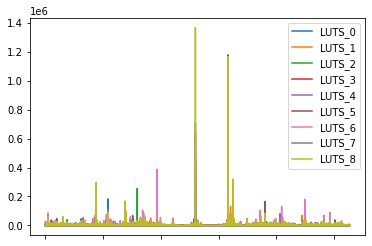

In [24]:
luts_genes.plot()

/usr/lib/python3/dist-packages/pandas/plotting/_core.py:394: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

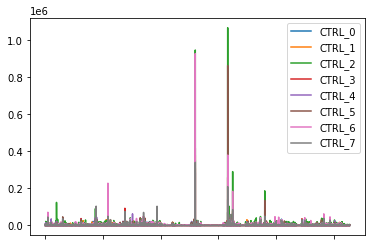

In [28]:
ctrl_genes.plot()

array([[<AxesSubplot:title={'center':'CTRL_0'}>,
        <AxesSubplot:title={'center':'CTRL_1'}>,
        <AxesSubplot:title={'center':'CTRL_2'}>],
       [<AxesSubplot:title={'center':'CTRL_3'}>,
        <AxesSubplot:title={'center':'CTRL_4'}>,
        <AxesSubplot:title={'center':'CTRL_5'}>],
       [<AxesSubplot:title={'center':'CTRL_6'}>,
        <AxesSubplot:title={'center':'CTRL_7'}>, <AxesSubplot:>]],
      dtype=object)

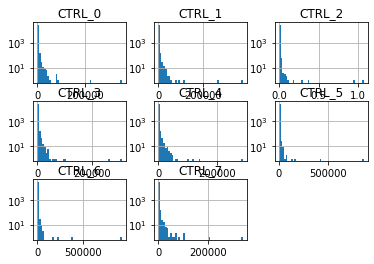

In [26]:
ctrl_genes.hist(log=True, bins=50)

array([[<AxesSubplot:title={'center':'LUTS_0'}>,
        <AxesSubplot:title={'center':'LUTS_1'}>,
        <AxesSubplot:title={'center':'LUTS_2'}>],
       [<AxesSubplot:title={'center':'LUTS_3'}>,
        <AxesSubplot:title={'center':'LUTS_4'}>,
        <AxesSubplot:title={'center':'LUTS_5'}>],
       [<AxesSubplot:title={'center':'LUTS_6'}>,
        <AxesSubplot:title={'center':'LUTS_7'}>,
        <AxesSubplot:title={'center':'LUTS_8'}>]], dtype=object)

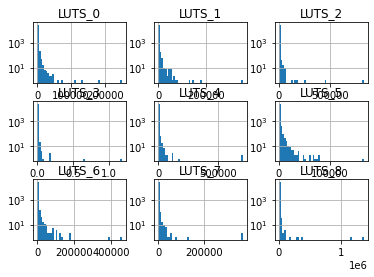

In [27]:
luts_genes.hist(log=True, bins=50)

In [19]:
genes_with_counts.shape

(26372, 18)

When would the above ways of selecting a column be more or less convenient?

In [29]:
genes_with_counts.max()

CTRL_0     351421.0
CTRL_1     378765.0
CTRL_2    1067780.0
CTRL_3     307923.0
CTRL_4     285201.0
CTRL_5     863397.0
CTRL_6     928390.0
CTRL_7     340901.0
CTRL_8     426979.0
LUTS_0     250132.0
LUTS_1     353868.0
LUTS_2     835469.0
LUTS_3    1178150.0
LUTS_4     708638.0
LUTS_5     165296.0
LUTS_6     455540.0
LUTS_7     366169.0
LUTS_8    1366150.0
dtype: float64

In [30]:
gene_sig = '../data/gene_exp_diff.tab'
sig_genes = pd.read_table(gene_sig)
sig_genes.set_index('genes')
#logq_vals = sig_genes.columns.set_index[['genes']]
#logq_vals.head()
#log_q_genes=sig_genes[["genes","logFC","q_value"]]

,logFC,p_value,q_value
genes,,,
A1BG,768.314000,1.00000,1.000000
A1BG-AS1,2.188480,1.00000,1.000000
A1CF,-2.501160,1.00000,1.000000
A2M,-0.494886,0.36735,0.999480
A2M-AS1,768.314000,1.00000,1.000000
A2ML1,0.731965,0.20445,0.961342
A2MP1,0.000000,1.00000,1.000000
A3GALT2,0.000000,1.00000,1.000000
A4GALT,-0.892046,0.42115,0.999480


Let's create a new data frame, `gene_count_data` that omits the length column. 

_Hands on.  There's a few ways to do this - the manual way..._

In [31]:
names = list(gene_data.columns)
gene_count_data = gene_data[names[1:]]
gene_count_data.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
A1BG,0.000,0.0,0.00,0.00,0.00,0.00,0.00000,0.0000,0.00000,0.00,0.0,0.000,0.0000,0.212403,0.00000,0.0000,0.0000
A1BG-AS1,0.000,0.0,0.00,0.00,0.00,0.00,7.14763,0.0000,0.00000,0.00,0.0,0.000,0.0000,22.727100,0.00000,14.9598,0.0000
A1CF,415.118,0.0,0.00,0.00,0.00,0.00,0.00000,84.2029,0.00000,0.00,0.0,0.000,34.6153,1.486820,1.39289,22.4397,20.1034
A2M,2628.850,0.0,1822.81,9870.74,1050.92,1473.34,3078.10000,6705.2100,3796.59000,1052.94,1021.8,703.598,1268.0100,7780.520000,3.48224,2403.1800,1825.7500
A2M-AS1,0.000,0.0,0.00,0.00,0.00,0.00,0.00000,0.0000,2.34575,0.00,0.0,0.000,0.0000,3.398440,0.00000,35.2623,0.0000


In [32]:
gene_count_data = gene_data[gene_data.columns[1:]]
gene_count_data.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
A1BG,0.000,0.0,0.00,0.00,0.00,0.00,0.00000,0.0000,0.00000,0.00,0.0,0.000,0.0000,0.212403,0.00000,0.0000,0.0000
A1BG-AS1,0.000,0.0,0.00,0.00,0.00,0.00,7.14763,0.0000,0.00000,0.00,0.0,0.000,0.0000,22.727100,0.00000,14.9598,0.0000
A1CF,415.118,0.0,0.00,0.00,0.00,0.00,0.00000,84.2029,0.00000,0.00,0.0,0.000,34.6153,1.486820,1.39289,22.4397,20.1034
A2M,2628.850,0.0,1822.81,9870.74,1050.92,1473.34,3078.10000,6705.2100,3796.59000,1052.94,1021.8,703.598,1268.0100,7780.520000,3.48224,2403.1800,1825.7500
A2M-AS1,0.000,0.0,0.00,0.00,0.00,0.00,0.00000,0.0000,2.34575,0.00,0.0,0.000,0.0000,3.398440,0.00000,35.2623,0.0000


Now that we've got the counts, we can look at plots a little more sensibly:

array([[<AxesSubplot:title={'center':'CTRL_1'}>,
        <AxesSubplot:title={'center':'CTRL_2'}>,
        <AxesSubplot:title={'center':'CTRL_3'}>,
        <AxesSubplot:title={'center':'CTRL_4'}>],
       [<AxesSubplot:title={'center':'CTRL_5'}>,
        <AxesSubplot:title={'center':'CTRL_6'}>,
        <AxesSubplot:title={'center':'CTRL_7'}>,
        <AxesSubplot:title={'center':'CTRL_8'}>],
       [<AxesSubplot:title={'center':'LUTS_0'}>,
        <AxesSubplot:title={'center':'LUTS_1'}>,
        <AxesSubplot:title={'center':'LUTS_2'}>,
        <AxesSubplot:title={'center':'LUTS_3'}>],
       [<AxesSubplot:title={'center':'LUTS_4'}>,
        <AxesSubplot:title={'center':'LUTS_5'}>,
        <AxesSubplot:title={'center':'LUTS_6'}>,
        <AxesSubplot:title={'center':'LUTS_7'}>],
       [<AxesSubplot:title={'center':'LUTS_8'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

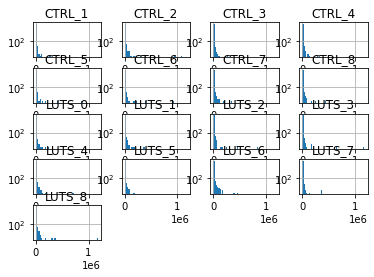

In [35]:
gene_count_data.hist(log=True, bins=50, range=[0,1178150])

Ok, now we want to skip rows that have all-zero (or maybe all-below-some-threshold) number of counts.  Let's play around with data frame rows.

When you index a data frame with a list or with a name, it selects columns; if you just use numbers, it selects rows:

You can select rows not just by numbers, but by whether a condition is true or false

So this gives us a way to select our rows... we just need a way to figure out if all of the relevant columns pass some criterion.  This would work:

But it's sort of too terrible to contemplate (what if we had 30 samples?)

In [36]:
(gene_count_data > 0).head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
A1BG,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
A1BG-AS1,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False
A1CF,True,False,False,False,False,False,False,True,False,False,False,False,True,True,True,True,True
A2M,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
A2M-AS1,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False


In [37]:
(gene_count_data > 0).all()

CTRL_1    False
CTRL_2    False
CTRL_3    False
CTRL_4    False
CTRL_5    False
CTRL_6    False
CTRL_7    False
CTRL_8    False
LUTS_0    False
LUTS_1    False
LUTS_2    False
LUTS_3    False
LUTS_4    False
LUTS_5    False
LUTS_6    False
LUTS_7    False
LUTS_8    False
dtype: bool

In [38]:
(gene_count_data > 0).all(axis=1)

A1BG           False
A1BG-AS1       False
A1CF           False
A2M            False
A2M-AS1        False
A2ML1           True
A2MP1          False
A3GALT2        False
A4GALT         False
A4GNT          False
AA06           False
AAAS           False
AACS           False
AACSP1         False
AADAC          False
AADACL2        False
AADACL2-AS1    False
AADACL3        False
AADACL4        False
AADACP1        False
AADAT          False
AAED1          False
AAGAB          False
AAK1            True
AAMDC          False
AAMP           False
AANAT          False
AAR2           False
AARD           False
AARS            True
               ...  
ZSCAN26        False
ZSCAN29        False
ZSCAN30        False
ZSCAN31        False
ZSCAN32        False
ZSCAN4         False
ZSCAN5A        False
ZSCAN5B        False
ZSCAN9         False
ZSWIM1          True
ZSWIM2         False
ZSWIM3         False
ZSWIM4          True
ZSWIM5         False
ZSWIM6          True
ZSWIM7         False
ZSWIM8       

In [40]:
expressed_genes=gene_count_data[(gene_count_data > 0).all(axis=1)]
expressed_genes


,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
A2ML1,5311.690000,1301.72000,922.81500,2542.81000,0.896693,6893.440000,9095.57000,15035.40000,1015.71000,3345.38000,10230.90000,12265.60000,17945.30000,415.4590,29502.900000,4206.9000,5.48275
AAK1,3398.780000,4177.44000,1718.87000,1155.21000,1167.490000,3136.570000,1620.41000,4365.99000,1241.49000,1055.64000,1118.08000,2053.41000,3734.81000,1760.1800,1893.640000,2256.7900,1.82758
AARS,991.516000,61.60820,623.66100,2000.72000,720.045000,1636.940000,643.70700,655.89600,1649.06000,582.27400,1.43713,219.56200,2889.47000,1102.1600,311.312000,783.2510,1586.34000
AASS,182.315000,1156.65000,10.14080,69.57350,7.173550,104.195000,177.00900,205.33700,2.93218,54.45340,1327.90000,414.17500,1513.97000,52.2510,181.076000,540.6890,49.34470
AATF,366.033000,4865.06000,1721.41000,1083.70000,1973.620000,3367.350000,660.10400,506.69400,847.40000,1684.28000,2096.77000,2178.16000,502.83300,1310.1000,576.658000,850.5700,2076.13000
ABCA1,5653.180000,21686.10000,12473.20000,14954.40000,7704.390000,6008.260000,10577.60000,17209.10000,2946.26000,10404.40000,6582.04000,5953.13000,6469.43000,20316.7000,11441.200000,8455.4800,14012.10000
ABCB5,46.981300,3.97473,2.53521,1.44945,1.793390,3.895150,51.29470,5.90897,29.32180,4.85228,1.43713,2.49503,14.57490,59.6851,5.571580,30.9881,7.31033
ABCC9,3305.520000,3370.57000,1749.29000,1625.80000,3519.520000,4227.210000,2081.64000,2960.40000,2273.03000,3687.73000,4032.58000,2926.67000,4713.15000,1385.9300,2584.520000,2621.1700,10377.00000
ABCD3,867.401000,433.24500,402.25300,557.55400,217.000000,2325.400000,785.81900,1352.42000,531.31100,744.55500,718.56300,1444.62000,4336.03000,698.1670,2035.020000,566.3340,1822.10000
ABCF1,435.453000,2086.73000,1497.46000,1603.57000,1047.340000,5097.770000,1674.23000,892.25500,1087.25000,1806.13000,1445.75000,239.52300,408.09700,1345.5700,1226.440000,1206.4000,5859.23000


In [44]:
expressed_genes.describe()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
count,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03,3.925000e+03
mean,2.230376e+03,3.312413e+03,2.071908e+03,2.129143e+03,2.124981e+03,2.656965e+03,2.085727e+03,2.129479e+03,2.051560e+03,2.541319e+03,2.804296e+03,2.525774e+03,2.889042e+03,2.111714e+03,3.017827e+03,2.001740e+03,3.248655e+03
std,6.135396e+03,1.023946e+04,4.286848e+03,4.481034e+03,5.167342e+03,8.765994e+03,4.528199e+03,5.167994e+03,5.386288e+03,6.631743e+03,1.476185e+04,1.979354e+04,1.283863e+04,5.020246e+03,1.057589e+04,6.968944e+03,9.978139e+03
min,9.534820e-309,2.277750e-163,1.323570e-95,2.586160e-73,6.607760e-102,8.941080e-317,8.590750e-28,6.606380e-169,1.287340e-291,3.956600e-131,7.472940e-316,1.859910e-262,8.212310e-163,1.763590e-53,1.261670e-40,1.336580e-257,3.922780e-234
25%,4.200270e+02,7.353240e+01,4.014080e+02,4.348340e+02,3.048760e+02,1.392510e+02,4.473570e+02,4.535140e+02,3.911530e+02,3.520600e+02,2.428740e+02,3.842340e+02,1.457490e+02,4.052640e+02,3.732960e+02,4.840560e+02,4.934470e+01
50%,1.084780e+03,1.043370e+03,1.047040e+03,1.074520e+03,1.037470e+03,1.222100e+03,1.018330e+03,1.064350e+03,1.030960e+03,9.828560e+02,1.185630e+03,1.102800e+03,1.293520e+03,1.023780e+03,1.037710e+03,1.058940e+03,1.242760e+03
75%,2.356780e+03,3.692520e+03,2.236050e+03,2.267420e+03,2.329610e+03,2.992450e+03,2.164890e+03,2.204050e+03,2.196200e+03,2.418590e+03,2.793770e+03,2.392730e+03,3.047970e+03,2.173090e+03,2.406220e+03,2.048420e+03,3.746540e+03
max,2.671770e+05,3.817050e+05,1.012090e+05,1.149050e+05,1.694820e+05,3.801140e+05,1.035370e+05,1.780680e+05,1.831940e+05,1.778900e+05,8.354690e+05,1.178150e+06,7.003450e+05,1.652960e+05,3.886980e+05,3.654750e+05,3.621080e+05


array([[<AxesSubplot:title={'center':'CTRL_1'}>,
        <AxesSubplot:title={'center':'CTRL_2'}>,
        <AxesSubplot:title={'center':'CTRL_3'}>,
        <AxesSubplot:title={'center':'CTRL_4'}>],
       [<AxesSubplot:title={'center':'CTRL_5'}>,
        <AxesSubplot:title={'center':'CTRL_6'}>,
        <AxesSubplot:title={'center':'CTRL_7'}>,
        <AxesSubplot:title={'center':'CTRL_8'}>],
       [<AxesSubplot:title={'center':'LUTS_0'}>,
        <AxesSubplot:title={'center':'LUTS_1'}>,
        <AxesSubplot:title={'center':'LUTS_2'}>,
        <AxesSubplot:title={'center':'LUTS_3'}>],
       [<AxesSubplot:title={'center':'LUTS_4'}>,
        <AxesSubplot:title={'center':'LUTS_5'}>,
        <AxesSubplot:title={'center':'LUTS_6'}>,
        <AxesSubplot:title={'center':'LUTS_7'}>],
       [<AxesSubplot:title={'center':'LUTS_8'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

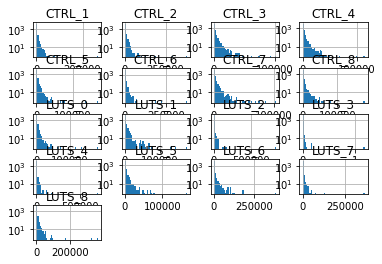

In [45]:
expressed_genes.hist(log=True, bins=50)

_Hands on - create a function which takes such a raw gene dataframe, applies a count threshold, and gets rid of the lengths_

In [46]:
def gene_counts_above_threshold(dataframe, threshold=0):
    """
    Returns a data frame from a given dataframe without any column named 'length', and 
    with rows such that every column is above threshold. 
    
    dataframe: an input pandas dataframe
    threshold: an threshold that all int64 columns must _exceed_ for the row to be kept
    returns a pandas dataframe with the column named 'length' stripped, 
             and with rows such that all int64 columns are strictly above threshold
    """
    no_length_column = dataframe[dataframe.columns.difference(["length"])]
    
    above_threshold = no_length_column[(no_length_column > threshold).all(axis=1)]
    return above_threshold

In [47]:
help(gene_counts_above_threshold)

Help on function gene_counts_above_threshold in module __main__:

gene_counts_above_threshold(dataframe, threshold=0)
    Returns a data frame from a given dataframe without any column named 'length', and 
    with rows such that every column is above threshold. 
    
    dataframe: an input pandas dataframe
    threshold: an threshold that all int64 columns must _exceed_ for the row to be kept
    returns a pandas dataframe with the column named 'length' stripped, 
             and with rows such that all int64 columns are strictly above threshold



In [50]:
genes_have_counts_data = gene_counts_above_threshold(expressed_genes, 5)
genes_have_counts_data.shape

(2684, 17)

In [49]:
genes_have_counts_data.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
AATF,366.033,4865.060,1721.410,1083.700,1973.62,3367.35,660.104,506.694,847.400,1684.280,2096.770,2178.160,502.833,1310.100,576.658,850.570,2076.13
ABCA1,5653.180,21686.100,12473.200,14954.400,7704.39,6008.26,10577.600,17209.100,2946.260,10404.400,6582.040,5953.130,6469.430,20316.700,11441.200,8455.480,14012.10
ABCC9,3305.520,3370.570,1749.290,1625.800,3519.52,4227.21,2081.640,2960.400,2273.030,3687.730,4032.580,2926.670,4713.150,1385.930,2584.520,2621.170,10377.00
ABCD3,867.401,433.245,402.253,557.554,217.00,2325.40,785.819,1352.420,531.311,744.555,718.563,1444.620,4336.030,698.167,2035.020,566.334,1822.10
ABCF1,435.453,2086.730,1497.460,1603.570,1047.34,5097.77,1674.230,892.255,1087.250,1806.130,1445.750,239.523,408.097,1345.570,1226.440,1206.400,5859.23


array([[<AxesSubplot:title={'center':'CTRL_1'}>,
        <AxesSubplot:title={'center':'CTRL_2'}>,
        <AxesSubplot:title={'center':'CTRL_3'}>,
        <AxesSubplot:title={'center':'CTRL_4'}>],
       [<AxesSubplot:title={'center':'CTRL_5'}>,
        <AxesSubplot:title={'center':'CTRL_6'}>,
        <AxesSubplot:title={'center':'CTRL_7'}>,
        <AxesSubplot:title={'center':'CTRL_8'}>],
       [<AxesSubplot:title={'center':'LUTS_0'}>,
        <AxesSubplot:title={'center':'LUTS_1'}>,
        <AxesSubplot:title={'center':'LUTS_2'}>,
        <AxesSubplot:title={'center':'LUTS_3'}>],
       [<AxesSubplot:title={'center':'LUTS_4'}>,
        <AxesSubplot:title={'center':'LUTS_5'}>,
        <AxesSubplot:title={'center':'LUTS_6'}>,
        <AxesSubplot:title={'center':'LUTS_7'}>],
       [<AxesSubplot:title={'center':'LUTS_8'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

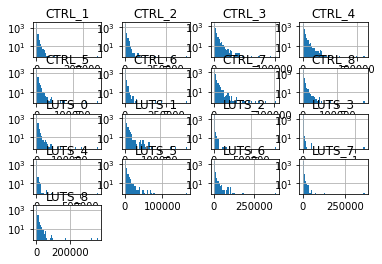

In [51]:
genes_have_counts_data.hist(log=True, bins=50)

Ok, so now we have the rows and columns we want, and we're ready to start doing some very crude analyses.
However, we need to scale the data across samples; we might just have more data overall from one sample
so that the counts would seem elevated compared to another.  A simple but crude way to do that scaling is
to scale by some average number of counts:

In [52]:
genes_have_counts_data.mean()

CTRL_1    2829.787373
CTRL_2    4370.152182
CTRL_3    2707.952366
CTRL_4    2756.735817
CTRL_5    2767.050522
CTRL_6    3408.658687
CTRL_7    2686.183397
CTRL_8    2697.992730
LUTS_0    2637.974540
LUTS_1    3376.292236
LUTS_2    3626.402440
LUTS_3    3258.733555
LUTS_4    3664.336268
LUTS_5    2754.246436
LUTS_6    3745.657346
LUTS_7    2594.431500
LUTS_8    4317.926786
dtype: float64

In [53]:
scaled_data = genes_have_counts_data / genes_have_counts_data.mean()

In [54]:
scaled_data.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
AATF,0.129350,1.113247,0.635687,0.393110,0.713258,0.987881,0.245740,0.187804,0.321231,0.498855,0.578196,0.668407,0.137223,0.475665,0.153954,0.327844,0.480816
ABCA1,1.997740,4.962321,4.606137,5.424676,2.784333,1.762646,3.937780,6.378483,1.116864,3.081605,1.815033,1.826823,1.765512,7.376500,3.054524,3.259088,3.245099
ABCC9,1.168116,0.771271,0.645983,0.589755,1.271939,1.240139,0.774943,1.097260,0.861657,1.092243,1.112006,0.898100,1.286222,0.503198,0.690004,1.010306,2.403237
ABCD3,0.306525,0.099137,0.148545,0.202252,0.078423,0.682204,0.292541,0.501269,0.201409,0.220524,0.198148,0.443307,1.183306,0.253487,0.543301,0.218288,0.421985
ABCF1,0.153882,0.477496,0.552986,0.581692,0.378504,1.495535,0.623275,0.330711,0.412153,0.534945,0.398673,0.073502,0.111370,0.488544,0.327430,0.464996,1.356954


In [55]:
scaled_data.describe()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
count,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000
mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,2.554228,2.777656,1.856569,1.905570,2.206353,3.052876,1.971756,2.209284,2.422737,2.323128,4.885474,7.320949,4.167761,2.153152,3.181690,3.212554,2.745233
min,0.001982,0.001343,0.001872,0.001928,0.001944,0.001714,0.002661,0.001916,0.002001,0.002076,0.001585,0.002297,0.001492,0.002699,0.001487,0.003707,0.001270
25%,0.245195,0.079014,0.261748,0.260263,0.214399,0.174979,0.265149,0.273699,0.251650,0.187869,0.173974,0.206724,0.156987,0.245062,0.166737,0.299014,0.098407
50%,0.536233,0.436341,0.553298,0.534108,0.520605,0.507226,0.527168,0.544660,0.530866,0.429551,0.460098,0.461300,0.499425,0.507939,0.390367,0.557596,0.512773
75%,1.058342,1.099491,1.070709,1.073036,1.072887,1.072730,1.033363,1.026244,1.038279,0.991323,0.971716,0.927386,1.061122,1.018193,0.833870,1.033164,1.104589
max,94.415928,87.343640,37.374734,41.681542,61.250056,111.514245,38.544278,66.000178,69.444946,52.687975,230.385076,361.536155,191.124654,60.014964,103.772973,140.869011,83.861542


Scaling by mean is actually a pretty bad idea, because a few highly-expressed genes can badly skew the mean.
A more robust method is to scale by the median - do that now

In [56]:
scaled_data = genes_have_counts_data / genes_have_counts_data.median()
print(scaled_data.head())
print(scaled_data.describe())

         CTRL_1     CTRL_2    CTRL_3     CTRL_4    CTRL_5    CTRL_6    CTRL_7  \
AATF   0.241220   2.551326  1.148905   0.736012  1.370056  1.947616  0.466152   
ABCA1  3.725509  11.372586  8.324874  10.156514  5.348265  3.475072  7.469687   
ABCC9  2.178375   1.767588  1.167513   1.104187  2.443195  2.444944  1.470012   
ABCD3  0.571627   0.227202  0.268472   0.378671  0.150638  1.344970  0.554929   
ABCF1  0.286968   1.094319  0.999436   1.089090  0.727047  2.948460  1.182307   

          CTRL_8    LUTS_0    LUTS_1    LUTS_2    LUTS_3    LUTS_4     LUTS_5  \
AATF    0.344809  0.605109  1.161340  1.256680  1.448962  0.274763   0.936461   
ABCA1  11.710934  2.103855  7.174013  3.944885  3.960160  3.535092  14.522405   
ABCC9   2.014576  1.623118  2.542754  2.416889  1.946889  2.575407   0.990665   
ABCD3   0.920333  0.379397  0.513384  0.430664  0.960995  2.369338   0.499051   
ABCF1   0.607187  0.776380  1.245358  0.866497  0.159336  0.222997   0.961815   

         LUTS_6    LUTS_7 

Let's do a little sanity check, and use a PCA to see if the samples we expect to be most similar in gene counts
in fact are - we expect the control samples (first three) to cluster together, and the treatment samples (last three)
to cluster together

[[-14.66583812   5.24846697]
 [ -7.60427107  -8.19871161]
 [ 23.48295433  -8.27975555]
 [ 27.92820292  -4.52858021]
 [  7.58266209 -18.44804434]
 [-18.01755821  -2.0545821 ]
 [ 19.33954551  18.45953203]
 [ 14.8624841   24.05962509]
 [ 10.99630949 -15.48428105]
 [ 17.36620007   3.6146011 ]
 [-27.63278616  -1.50572516]
 [-32.05663102  -4.2919961 ]
 [-27.23811854   0.48446195]
 [ 33.66649919 -11.26858757]
 [ -3.79348361  38.31895027]
 [-19.58887197  -7.71556598]
 [ -4.627299    -8.40980774]]


Text(0, 0.5, '2nd PCA')

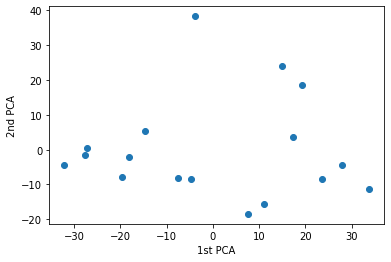

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca = PCA(n_components=2).fit_transform(scale(scaled_data).T)
print(pca)
plt.scatter(pca[:,0], pca[:,1])
plt.xlabel("1st PCA")
plt.ylabel("2nd PCA")

So this seems promising.  Now let's generate an MA plot - mean expression of the gene across all samples, 
_vs_ the change in expression, all log2 scaled

In [58]:
np.log2(scaled_data.mean(axis=1))[:5]

AATF    -0.051009
ABCA1    2.780706
ABCC9    1.039854
ABCD3   -0.481510
ABCF1    0.040683
dtype: float64

In [59]:
A_untreated = np.log2(scaled_data[scaled_data.columns[0:3]].mean(axis=1))
A_treated = np.log2(scaled_data[scaled_data.columns[3:7]].mean(axis=1))
A = 1./2. *(A_untreated + A_treated)
M = A_treated - A_untreated

print(A_untreated[:5])
print(A_treated[:5])
print(M[:5])

AATF     0.393764
ABCA1    2.964890
ABCC9    0.769342
ABCD3   -1.490996
ABCF1   -0.333562
dtype: float64
AATF     0.176270
ABCA1    2.725171
ABCC9    0.899628
ABCD3   -0.719513
ABCF1    0.572139
dtype: float64
AATF    -0.217494
ABCA1   -0.239719
ABCC9    0.130286
ABCD3    0.771483
ABCF1    0.905701
dtype: float64


In [60]:
scaled_data['M'] = M
scaled_data['A'] = A

Text(0, 0.5, 'M')

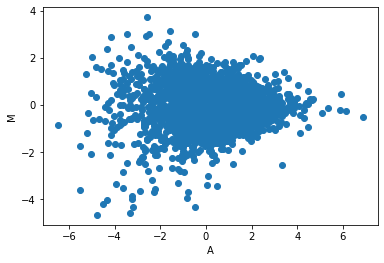

In [61]:
plt.scatter(scaled_data.A, scaled_data.M)
plt.xlabel('A')
plt.ylabel('M')

Now we're going to make a volcano plot: p-value of change in expression vs change in expression

We'll calculate the p-values _very_ crudely by doing a 2-sided independent t-test of the scaled counts in the 
control and treatment samples.   This will require looking at the data a little differently - we're going to
be processing subsets of columns for each row.

In [62]:
from scipy.stats import ttest_ind

In [63]:
onerow = scaled_data[0:1]
onerow.values[0]

array([ 0.24121983,  2.55132612,  1.14890493,  0.73601174,  1.37005567,
        1.94761591,  0.4661521 ,  0.34480942,  0.6051085 ,  1.16134015,
        1.25667965,  1.44896242,  0.27476312,  0.9364613 ,  0.39438236,
        0.58796042,  0.93767939, -0.21749406,  0.28501727])

In [64]:
onerow.values[0][0:3]

array([0.24121983, 2.55132612, 1.14890493])

In [65]:
ttest_ind(onerow.values[0][0:3], onerow.values[0][3:6])

Ttest_indResult(statistic=-0.04938164507092932, pvalue=0.9629825697004917)

In [66]:
ttest_ind(onerow.values[0][0:3], onerow.values[0][3:7]).pvalue

0.7993317719397521

In [67]:
def gene_pvalue(dataframe_row):
    control = dataframe_row[0:3]
    treatment = dataframe_row[3:7]
    return ttest_ind(control, treatment).pvalue

In [68]:
gene_pvalue(onerow.values[0])

0.7993317719397521

In [69]:
foo = scaled_data.apply(gene_pvalue, axis=1)

Hands on: make a "p_value" column in the scaled_data dataframe, and plot M along x axis and -log10 p_value along y axis

Text(0, 0.5, '-Log10 p_value')

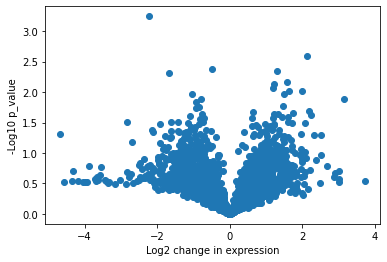

In [70]:
scaled_data['p_value'] = scaled_data.apply(gene_pvalue, axis=1)
plt.scatter(scaled_data['M'], -np.log10(scaled_data['p_value']))
plt.xlabel('Log2 change in expression')
plt.ylabel('-Log10 p_value')

In [73]:
sorted_data = scaled_data.sort_values('p_value')
sorted_data.shape

(2684, 20)

In [74]:
sorted_data.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8,M,A,p_value
LYRM7,0.362754,0.307452,0.267908,0.085972,0.072206,0.014081,0.096497,0.031666,0.316583,0.108922,0.024117,0.069709,0.050772,0.134214,0.020481,0.142558,0.113908,-2.218506,-2.786380,0.000571
CHM,0.044824,0.008338,0.126904,0.293684,0.209773,0.274289,0.268112,0.145263,0.327471,0.020074,0.014643,0.033195,0.588352,0.344492,0.059062,0.076819,0.011556,2.123049,-2.996839,0.002610
ZFP36L1,7.598465,8.928587,7.884977,5.983605,6.434476,5.530267,5.104218,6.490565,3.386515,8.779554,6.978484,4.353526,3.653558,4.189322,11.443256,6.082729,14.037166,-0.497702,2.775707,0.004266
SWAP70,0.711185,0.224075,0.748452,1.289586,1.248678,1.381015,1.575713,1.666748,0.631491,0.441637,0.714900,0.763483,0.084619,1.258179,1.530851,1.034843,0.950886,1.291434,-0.187600,0.004438
CPT1A,0.585490,0.360605,0.587705,0.111895,0.138188,0.140242,0.252079,0.107062,0.114741,0.488477,0.155901,0.006639,0.011946,0.329310,0.098119,0.136649,0.023937,-1.670594,-1.803149,0.004875


Now you could start applying the appropriate multiple-hypothesis testing corrections to see if any of these changes were significant.  A Bonferroni correction would look like

In [75]:
sorted_data['bonferroni'] = sorted_data['p_value'] * sorted_data.shape[0]

In [76]:
sorted_data.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,...,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8,M,A,p_value,bonferroni
LYRM7,0.362754,0.307452,0.267908,0.085972,0.072206,0.014081,0.096497,0.031666,0.316583,0.108922,...,0.069709,0.050772,0.134214,0.020481,0.142558,0.113908,-2.218506,-2.786380,0.000571,1.532570
CHM,0.044824,0.008338,0.126904,0.293684,0.209773,0.274289,0.268112,0.145263,0.327471,0.020074,...,0.033195,0.588352,0.344492,0.059062,0.076819,0.011556,2.123049,-2.996839,0.002610,7.006341
ZFP36L1,7.598465,8.928587,7.884977,5.983605,6.434476,5.530267,5.104218,6.490565,3.386515,8.779554,...,4.353526,3.653558,4.189322,11.443256,6.082729,14.037166,-0.497702,2.775707,0.004266,11.450809
SWAP70,0.711185,0.224075,0.748452,1.289586,1.248678,1.381015,1.575713,1.666748,0.631491,0.441637,...,0.763483,0.084619,1.258179,1.530851,1.034843,0.950886,1.291434,-0.187600,0.004438,11.912338
CPT1A,0.585490,0.360605,0.587705,0.111895,0.138188,0.140242,0.252079,0.107062,0.114741,0.488477,...,0.006639,0.011946,0.329310,0.098119,0.136649,0.023937,-1.670594,-1.803149,0.004875,13.084596


## Advanced - simple aggregation 

In [ ]:
genes_with_families = genes_have_counts_data

def phony_family_from_name(gene_name):
    return int(gene_name[-1])

families = list(map(phony_family_from_name, genes_have_counts_data.index))
genes_with_families['family'] = families

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-77-6f2e8bc3bb51>", line 6, in <module>
    families = list(map(phony_family_from_name, genes_have_counts_data.index))
  File "<ipython-input-77-6f2e8bc3bb51>", line 4, in phony_family_from_name
    return int(gene_name[-1])
ValueError: invalid literal for int() with base 10: 'F'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPyt

In [77]:
genes_with_families.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,LUTS_0,LUTS_1,LUTS_2,LUTS_3,LUTS_4,LUTS_5,LUTS_6,LUTS_7,LUTS_8
AATF,366.033,4865.060,1721.410,1083.700,1973.62,3367.35,660.104,506.694,847.400,1684.280,2096.770,2178.160,502.833,1310.100,576.658,850.570,2076.13
ABCA1,5653.180,21686.100,12473.200,14954.400,7704.39,6008.26,10577.600,17209.100,2946.260,10404.400,6582.040,5953.130,6469.430,20316.700,11441.200,8455.480,14012.10
ABCC9,3305.520,3370.570,1749.290,1625.800,3519.52,4227.21,2081.640,2960.400,2273.030,3687.730,4032.580,2926.670,4713.150,1385.930,2584.520,2621.170,10377.00
ABCD3,867.401,433.245,402.253,557.554,217.00,2325.40,785.819,1352.420,531.311,744.555,718.563,1444.620,4336.030,698.167,2035.020,566.334,1822.10
ABCF1,435.453,2086.730,1497.460,1603.570,1047.34,5097.77,1674.230,892.255,1087.250,1806.130,1445.750,239.523,408.097,1345.570,1226.440,1206.400,5859.23


ERROR! Session/line number was not unique in database. History logging moved to new session 141


We can do simple things like find out how many are in each family:

In [ ]:
genes_with_families['family'].value_counts()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/pandas/core/indexes/base.py", line 2525, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 117, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 139, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1265, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1273, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'family'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-30084c62f4b8>", line 1, in <module>
    genes_with_families['family'].value_counts()
  File "/usr/lib/python3/dist-packages

Now we can start aggregating data by family:

In [ ]:
family_data = genes_with_families.groupby('family').aggregate('mean')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 142
Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-8a37a8c9f959>", line 1, in <module>
    family_data = genes_with_families.groupby('family').aggregate('mean')
  File "/usr/lib/python3/dist-packages/pandas/core/generic.py", line 5162, in groupby
    **kwargs)
  File "/usr/lib/python3/dist-packages/pandas/core/groupby.py", line 1848, in groupby
    return klass(obj, by, **kwds)
  File "/usr/lib/python3/dist-packages/pandas/core/groupby.py", line 516, in __init__
    mutated=self.mutated)
  File "/usr/lib/python3/dist-packages/pandas/core/groupby.py", line 2934, in _get_grouper
    raise KeyError(gpr)
KeyError: 'family'

During handling of the above exception, another exception occurred:

Traceback (most recent call las

In [ ]:
family_data.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-db7cbefb02e9>", line 1, in <module>
    family_data.head()
NameError: name 'family_data' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/drew/.local/lib/python3.6/site-pack

In [ ]:
family_data.plot(kind='bar')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-fac83eae9d51>", line 1, in <module>
    family_data.plot(kind='bar')
NameError: name 'family_data' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/drew/.local/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/drew/.local/lib/python3.6